# NN analysis

### Imports

In [8]:
import pandas as pd
import numpy as np
import time

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Subset


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

import sys
from pathlib import Path
import importlib

# Sørg for at code/ er på path
sys.path.append(str(Path("..").resolve()))

from Implementations import prepare_data
importlib.reload(prepare_data)

from Implementations.prepare_data import prepare_data


from Implementations import plot_style
importlib.reload(plot_style)
from Implementations.plot_style import set_latex_style, fig_ax, save_pdf




### Data prep

In [3]:
df = pd.read_csv("../Data_Processed/player_core_features.csv")

data = prepare_data(df, test_size=0.2, seed=6114)
print(data["summary"])

X_train = data["X_train"]
X_test  = data["X_test"]
y_train = data["ylog_train"].ravel()
y_test  = data["ylog_test"].ravel()

feature_cols = data["feature_cols"]
groups_train = data["groups_train"]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)


{'n_rows_total': 278558, 'n_rows_used': 275230, 'n_features': 24, 'test_size': 0.2, 'seed': 6114, 'numeric_only': True, 'drop_na': True, 'standardize': True, 'player_overlap_train_test': 0}


### Create DataLoaders for Training and Evaluation

In [4]:
train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=256,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test_t, y_test_t),
    batch_size=2048,
    shuffle=False
)


### Creating FFNN with arbitrary architecture

Architecture:
- Input layer:        d_in features
- Hidden layer 1:     128 units + ReLU
- Hidden layer 2:      64 units + ReLU
- Output layer:        1 unit (linear)

In [5]:
class MLP(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(d_in=X_train.shape[1])


### Training the network

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()

def train_epoch():
    model.train()
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

@torch.no_grad()
def eval_model():
    model.eval()
    preds = []
    for xb, _ in test_loader:
        preds.append(model(xb).numpy())
    yhat = np.vstack(preds).ravel()
    rmse = np.sqrt(mean_squared_error(y_test, yhat))
    r2 = r2_score(y_test, yhat)
    return rmse, r2

for epoch in range(1, 21):
    train_epoch()
    rmse, r2 = eval_model()
    print(f"Epoch {epoch:02d} | RMSE(log)={rmse:.4f} | R2(log)={r2:.4f}")


Epoch 01 | RMSE(log)=1.3577 | R2(log)=0.1942
Epoch 02 | RMSE(log)=1.0792 | R2(log)=0.4908
Epoch 03 | RMSE(log)=1.0040 | R2(log)=0.5593
Epoch 04 | RMSE(log)=0.9897 | R2(log)=0.5718
Epoch 05 | RMSE(log)=0.9957 | R2(log)=0.5666
Epoch 06 | RMSE(log)=0.9731 | R2(log)=0.5860
Epoch 07 | RMSE(log)=0.9697 | R2(log)=0.5889
Epoch 08 | RMSE(log)=0.9722 | R2(log)=0.5868
Epoch 09 | RMSE(log)=0.9689 | R2(log)=0.5896
Epoch 10 | RMSE(log)=0.9734 | R2(log)=0.5858
Epoch 11 | RMSE(log)=0.9774 | R2(log)=0.5824
Epoch 12 | RMSE(log)=0.9727 | R2(log)=0.5864
Epoch 13 | RMSE(log)=0.9740 | R2(log)=0.5853
Epoch 14 | RMSE(log)=0.9699 | R2(log)=0.5888
Epoch 15 | RMSE(log)=0.9757 | R2(log)=0.5838
Epoch 16 | RMSE(log)=0.9693 | R2(log)=0.5893
Epoch 17 | RMSE(log)=0.9733 | R2(log)=0.5859
Epoch 18 | RMSE(log)=0.9725 | R2(log)=0.5866
Epoch 19 | RMSE(log)=0.9714 | R2(log)=0.5875
Epoch 20 | RMSE(log)=0.9770 | R2(log)=0.5827


### Testing different architectures

In [ ]:
### Data Prep ###
X_train = data["X_train"]                         
X_test  = data["X_test"]                          
y_train = data["ylog_train"].ravel()
y_test  = data["ylog_test"].ravel()
groups_train = data["groups_train"] # Only training data

# Torch tensors (float32)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)


# Splitting training data into train/val datasets

VAL_SIZE = 0.2
gss = GroupShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=6114)
tr_idx, va_idx = next(gss.split(X_train, y_train, groups=groups_train))

train_ds_full = TensorDataset(X_train_t, y_train_t)
test_ds       = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(Subset(train_ds_full, tr_idx), batch_size=256, shuffle=True,  num_workers=0)
val_loader   = DataLoader(Subset(train_ds_full, va_idx), batch_size=2048, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,                 batch_size=2048, shuffle=False, num_workers=0)


### Build models###

device = "cpu"  # use "cuda" only if stable. Sometimes we experienced kernel crashing
torch.manual_seed(6114)
np.random.seed(6114)

def make_activation(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU
    if name == "tanh":
        return nn.Tanh
    raise ValueError("activation must be 'relu' or 'tanh'")

class MLP(nn.Module):
    def __init__(self, d_in: int, n_layers: int, n_units: int, activation: str, dropout: float = 0.1):
        super().__init__()
        Act = make_activation(activation)
        layers = []
        prev = d_in
        for _ in range(n_layers):
            layers.append(nn.Linear(prev, n_units))
            layers.append(Act())
            if dropout and dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = n_units
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

@torch.no_grad()
def eval_model(model: nn.Module, loader: DataLoader):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds.append(pred)
        trues.append(yb.numpy())
    yhat = np.vstack(preds).ravel()
    ytrue = np.vstack(trues).ravel()
    rmse = np.sqrt(mean_squared_error(ytrue, yhat))
    r2 = r2_score(ytrue, yhat)
    return rmse, r2


### Train one configuration (early stopping on VAL) ###

def train_one_config(
    n_layers: int,
    n_units: int,
    activation: str,
    *,
    lr: float = 5e-4,
    weight_decay: float = 1e-5,
    dropout: float = 0.1,
    max_epochs: int = 30,
    patience: int = 6,
    clip_norm: float = 5.0,
    seed: int = 6114,
):
    # reproducible init per config
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = MLP(
        d_in=X_train.shape[1],
        n_layers=n_layers,
        n_units=n_units,
        activation=activation,
        dropout=dropout
    ).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    best_rmse = np.inf
    best_r2 = -np.inf
    best_epoch = 0
    best_state = None
    bad = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)

            opt.zero_grad()
            loss.backward()
            if clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            opt.step()

        # EARLY STOPPING METRIC: VALIDATION ONLY
        rmse_val, r2_val = eval_model(model, val_loader)

        if rmse_val < best_rmse - 1e-4:
            best_rmse = rmse_val
            best_r2 = r2_val
            best_epoch = epoch
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    # restore best weights (by validation)
    if best_state is not None:
        model.load_state_dict(best_state)

    # final validation metrics of best model
    rmse_val, r2_val = eval_model(model, val_loader)

    # count params
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return model, {
        "activation": activation,
        "n_layers": int(n_layers),
        "n_units": int(n_units),
        "n_params": int(n_params),
        "best_epoch": int(best_epoch),
        "rmse_val_log": float(rmse_val),
        "r2_val_log": float(r2_val),
    }


# Sweeping architectures
def run_sweep(activation: str, layers_grid, units_grid):
    rows = []
    t0 = time.time()

    for L in layers_grid:
        for H in units_grid:
            _, res = train_one_config(L, H, activation)
            rows.append(res)
            print(f"[{activation}] layers={L}, units={H} -> "
                  f"VAL RMSE(log)={res['rmse_val_log']:.4f}, VAL R2(log)={res['r2_val_log']:.4f}, best_epoch={res['best_epoch']}")

    df_res = pd.DataFrame(rows).sort_values(["n_layers", "n_units"]).reset_index(drop=True)
    print(f"Done {activation} sweep in {time.time()-t0:.1f}s")
    return df_res

layers_grid = [1, 2, 3]
units_grid  = [32, 64, 128, 256]

relu_results = run_sweep("relu", layers_grid, units_grid)
tanh_results = run_sweep("tanh", layers_grid, units_grid)

all_results = pd.concat([relu_results, tanh_results], ignore_index=True)
display(all_results)

all_results.to_csv("../Tables/mlp_arch_sweep_results_core_features.csv", index=False)
print("Saved: ../Tables/mlp_arch_sweep_results_core_features.csv")


### Train BEST config (by validation) and evaluate ONCE on TEST ###

best_row = all_results.sort_values("rmse_val_log").iloc[0]
print("Best config (by VAL):", best_row.to_dict())

best_model, _ = train_one_config(
    n_layers=int(best_row["n_layers"]),
    n_units=int(best_row["n_units"]),
    activation=str(best_row["activation"]),
)

rmse_test, r2_test = eval_model(best_model, test_loader)
print(f"BEST MLP (core_features) | TEST RMSE(log)={rmse_test:.4f} | TEST R2(log)={r2_test:.4f}")



[relu] layers=1, units=32 -> VAL RMSE(log)=0.9583, VAL R2(log)=0.5936, best_epoch=27
[relu] layers=1, units=64 -> VAL RMSE(log)=0.9675, VAL R2(log)=0.5858, best_epoch=29
[relu] layers=1, units=128 -> VAL RMSE(log)=0.9515, VAL R2(log)=0.5994, best_epoch=30
[relu] layers=1, units=256 -> VAL RMSE(log)=0.9542, VAL R2(log)=0.5971, best_epoch=16
[relu] layers=2, units=32 -> VAL RMSE(log)=0.9457, VAL R2(log)=0.6042, best_epoch=29
[relu] layers=2, units=64 -> VAL RMSE(log)=0.9398, VAL R2(log)=0.6092, best_epoch=30
[relu] layers=2, units=128 -> VAL RMSE(log)=0.9435, VAL R2(log)=0.6060, best_epoch=15
[relu] layers=2, units=256 -> VAL RMSE(log)=0.9451, VAL R2(log)=0.6047, best_epoch=16
[relu] layers=3, units=32 -> VAL RMSE(log)=0.9432, VAL R2(log)=0.6063, best_epoch=29
[relu] layers=3, units=64 -> VAL RMSE(log)=0.9405, VAL R2(log)=0.6086, best_epoch=26
[relu] layers=3, units=128 -> VAL RMSE(log)=0.9441, VAL R2(log)=0.6056, best_epoch=15
[relu] layers=3, units=256 -> VAL RMSE(log)=0.9594, VAL R2(l

,activation,n_layers,n_units,n_params,best_epoch,rmse_val_log,r2_val_log
0,relu,1,32,833,27,0.958301,0.593610
1,relu,1,64,1665,29,0.967495,0.585775
2,relu,1,128,3329,30,0.951468,0.599384
3,relu,1,256,6657,16,0.954156,0.597117
4,relu,2,32,1889,29,0.945734,0.604198
5,relu,2,64,5825,30,0.939760,0.609183
6,relu,2,128,19841,15,0.943547,0.606027
7,relu,2,256,72449,16,0.945116,0.604715
8,relu,3,32,2945,29,0.943245,0.606279
9,relu,3,64,9985,26,0.940483,0.608582


Saved: mlp_arch_sweep_results_core_features.csv
Best config (by VAL): {'activation': 'relu', 'n_layers': 2, 'n_units': 64, 'n_params': 5825, 'best_epoch': 30, 'rmse_val_log': 0.9397601222807055, 'r2_val_log': 0.6091829538345337}
BEST MLP (core_features) | TEST RMSE(log)=0.9596 | TEST R2(log)=0.5975


### Plotting heatmaps

Saved: ../Plots/fig_nn_core_architecture_heatmap_relu.pdf
Saved: ../Plots/fig_nn_core_architecture_heatmap_tanh.pdf


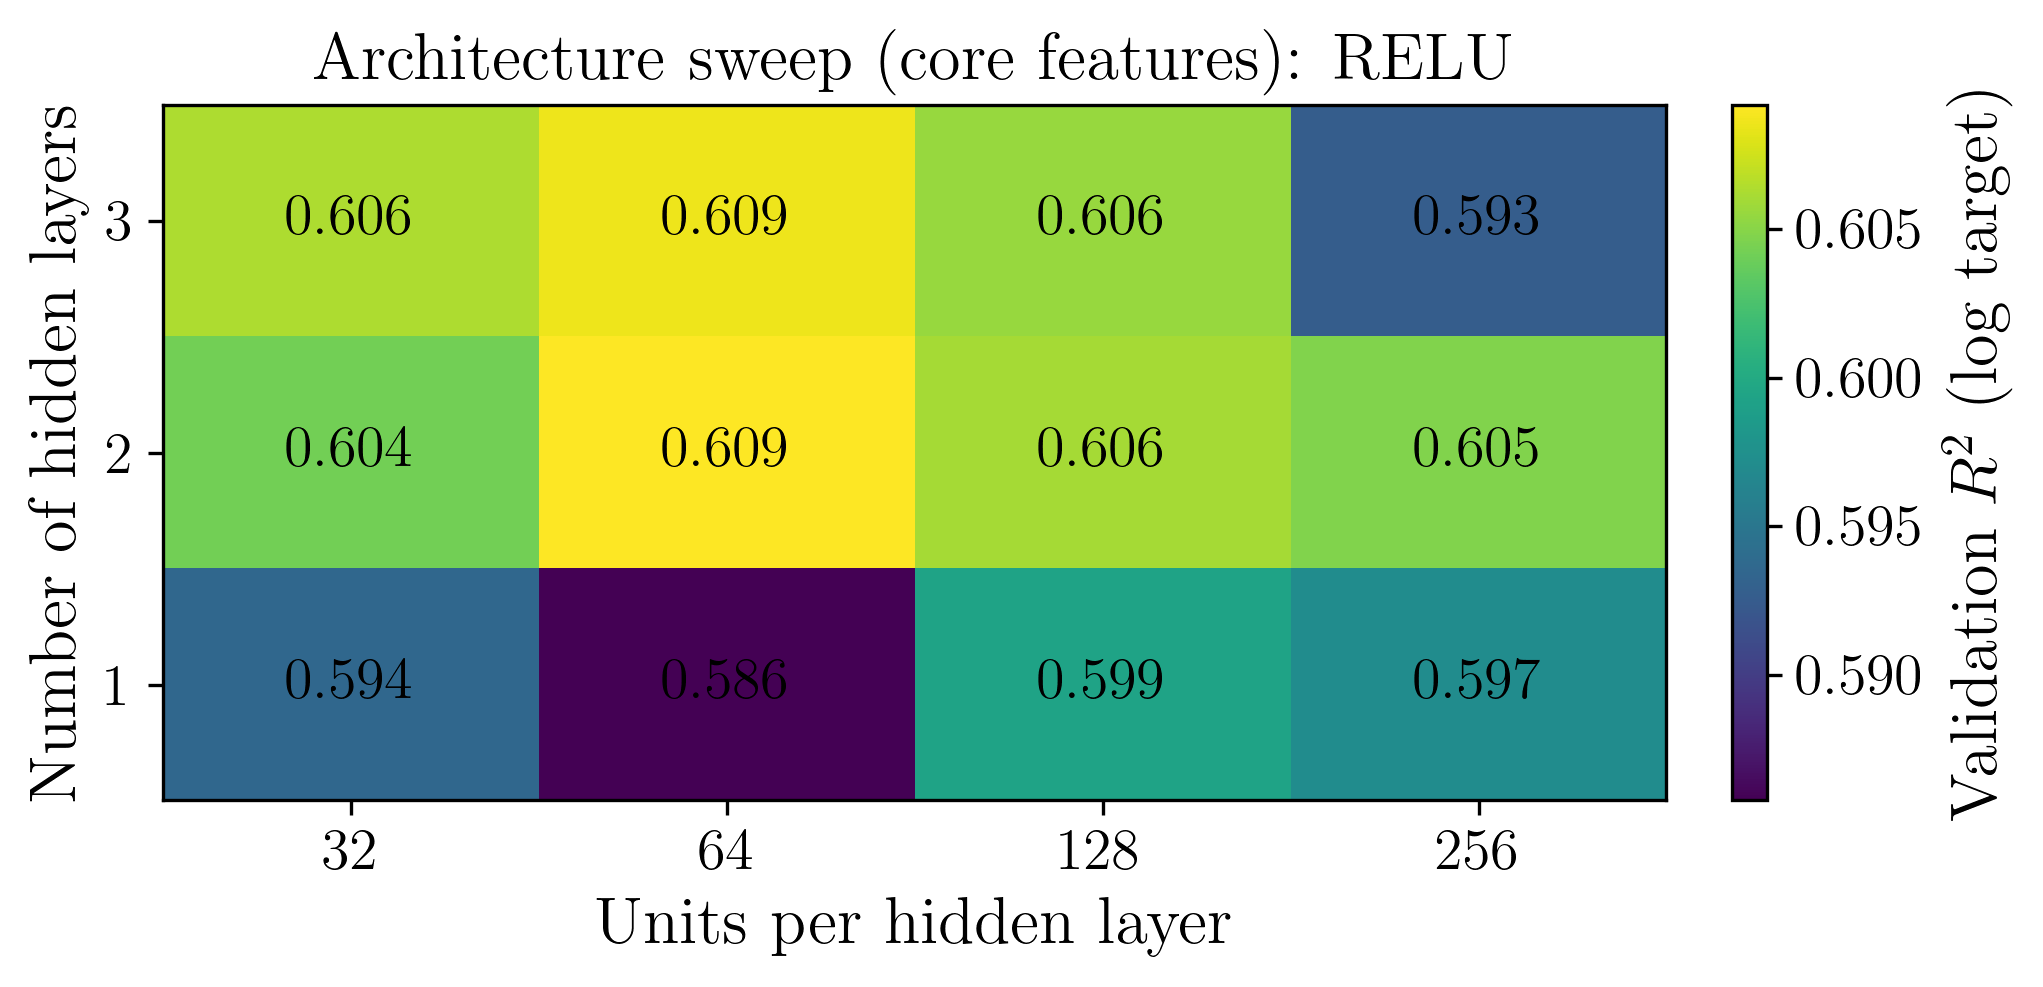

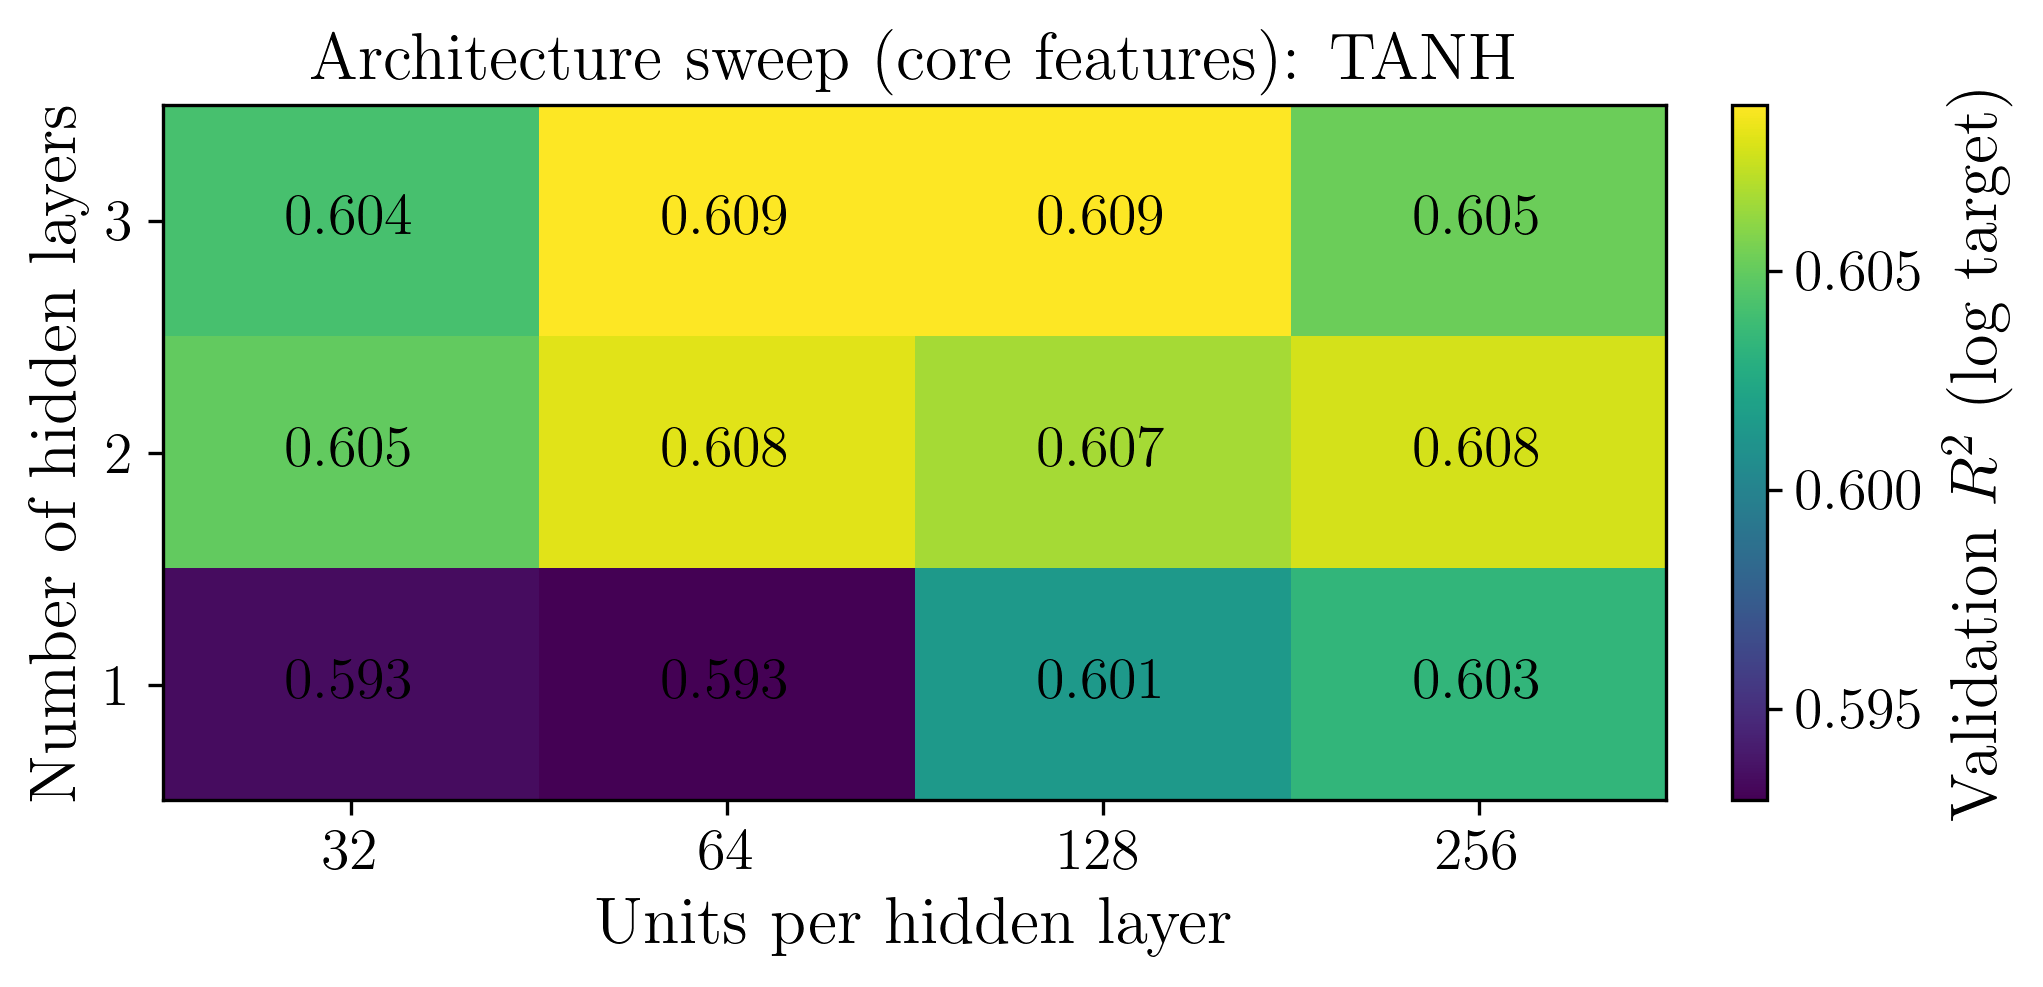

In [ ]:


# -----------------------
# Load sweep results
# -----------------------
df = pd.read_csv("../Tables/mlp_arch_sweep_results_core_features.csv")

col_act    = "activation"
col_layers = "n_layers"
col_units  = "n_units"
col_r2     = "r2_val_log"

df[col_act] = df[col_act].astype(str).str.lower().str.strip()
df[col_layers] = df[col_layers].astype(int)
df[col_units]  = df[col_units].astype(int)

# -----------------------
# Heatmap helper
# -----------------------
def plot_heatmap(act: str, metric_col: str, metric_label: str, outname: str):
    sub = df[df[col_act] == act].copy()
    if sub.empty:
        raise ValueError(
            f"No rows found for activation='{act}'. "
            f"Available activations: {sorted(df[col_act].unique())}"
        )

    pivot = sub.pivot_table(index=col_layers, columns=col_units, values=metric_col, aggfunc="mean")
    pivot = pivot.sort_index().sort_index(axis=1)

    layers = pivot.index.to_list()
    units  = pivot.columns.to_list()
    Z = pivot.values

    # 1) Apply LaTeX look FIRST (this sets small default fonts)
    set_latex_style(usetex=True)

    # 2) Override fonts AFTER set_latex_style (this is the key fix)
    mpl.rcParams.update({
        "axes.labelsize": 16,
        "axes.titlesize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
    })

    fig, ax = fig_ax("twocol", height_scale=1.05)

    im = ax.imshow(Z, aspect="auto", origin="lower")

    ax.set_xticks(np.arange(len(units)))
    ax.set_xticklabels([str(u) for u in units])
    ax.set_yticks(np.arange(len(layers)))
    ax.set_yticklabels([str(l) for l in layers])

    ax.set_xlabel("Units per hidden layer")
    ax.set_ylabel("Number of hidden layers")
    ax.set_title(f"Architecture sweep (core features): {act.upper()}")

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(metric_label, fontsize=16)
    cbar.ax.tick_params(labelsize=14)

    # Annotate cells (bigger!)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            val = Z[i, j]
            if np.isfinite(val):
                ax.text(
                    j, i, f"{val:.3f}",
                    ha="center", va="center",
                    fontsize=14,
                    fontweight="bold",
                    color="black"
                )

    fig.tight_layout()
    save_pdf(fig, outname + ".pdf", folder="../Plots")
    print(f"Saved: ../Plots/{outname}.pdf")


# -----------------------
# Produce heatmaps
# -----------------------
plot_heatmap(
    act="relu",
    metric_col=col_r2,
    metric_label=r"Validation $R^2$ (log target)",
    outname="fig_nn_core_architecture_heatmap_relu",
)

plot_heatmap(
    act="tanh",
    metric_col=col_r2,
    metric_label=r"Validation $R^2$ (log target)",
    outname="fig_nn_core_architecture_heatmap_tanh",
)


### NN with optimal architecture (ReLU, 2*64)

In [12]:
# FINAL BEST MLP (core): ReLU [64-64-1], 30 epochs, train on FULL train set, eval once on TEST


# Reproducibility
SEED = 6114
torch.manual_seed(SEED)
np.random.seed(SEED)

# Best architecture from sweep (fixed)
ACT = "relu"
N_LAYERS = 2
N_UNITS = 64
EPOCHS = 30

# Keep hyperparams consistent with sweep
LR = 5e-4
WEIGHT_DECAY = 1e-5
DROPOUT = 0.1
CLIP_NORM = 5.0
BATCH_SIZE = 256

# Full training loader (no validation split)
full_train_loader = DataLoader(
    train_ds_full,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# Build model
best_model = MLP(
    d_in=X_train.shape[1],
    n_layers=N_LAYERS,
    n_units=N_UNITS,
    activation=ACT,
    dropout=DROPOUT
).to(device)

opt = torch.optim.Adam(best_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()

# Fixed-epoch training
for epoch in range(1, EPOCHS + 1):
    best_model.train()
    for xb, yb in full_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = best_model(xb)
        loss = loss_fn(pred, yb)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(best_model.parameters(), CLIP_NORM)
        opt.step()

# Evaluate once on test
rmse_test, r2_test = eval_model(best_model, test_loader)
print(f"FINAL MLP (core) | ReLU [64-64-1] | epochs=30 | TEST RMSE(log)={rmse_test:.4f} | TEST R2={r2_test:.4f}")

# Store results (nice for table/plot notebook later)
final_nn_core = {
    "model": "NN",
    "features": "Core",
    "activation": "relu",
    "architecture": "[64--64--1]",
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "lr": LR,
    "weight_decay": WEIGHT_DECAY,
    "dropout": DROPOUT,
    "rmse_test_log": float(rmse_test),
    "r2_test": float(r2_test),
}
final_nn_core


FINAL MLP (core) | ReLU [64-64-1] | epochs=30 | TEST RMSE(log)=0.9537 | TEST R2=0.6024


{'model': 'NN',
 'features': 'Core',
 'activation': 'relu',
 'architecture': '[64--64--1]',
 'epochs': 30,
 'batch_size': 256,
 'lr': 0.0005,
 'weight_decay': 1e-05,
 'dropout': 0.1,
 'rmse_test_log': 0.9536510329188976,
 'r2_test': 0.6024450063705444}

### Plotting residuals and predictions on best NN

In [13]:
# Get predictions and residuals for NN (core) on test set
@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    preds, trues = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds.append(pred)
        trues.append(yb.numpy())
    yhat = np.vstack(preds).ravel()
    ytrue = np.vstack(trues).ravel()
    return ytrue, yhat

ytrue_test, yhat_test = predict_all(best_model, test_loader)
residuals_test = ytrue_test - yhat_test


'../Plots/fig_nn_core_residuals.pdf'

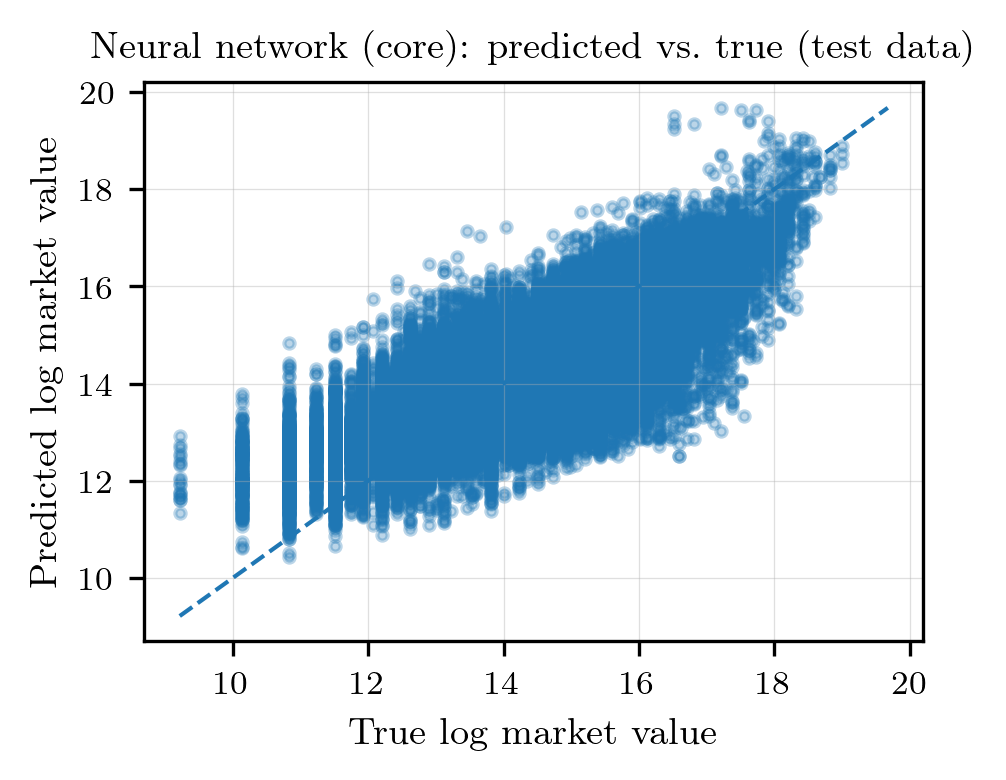

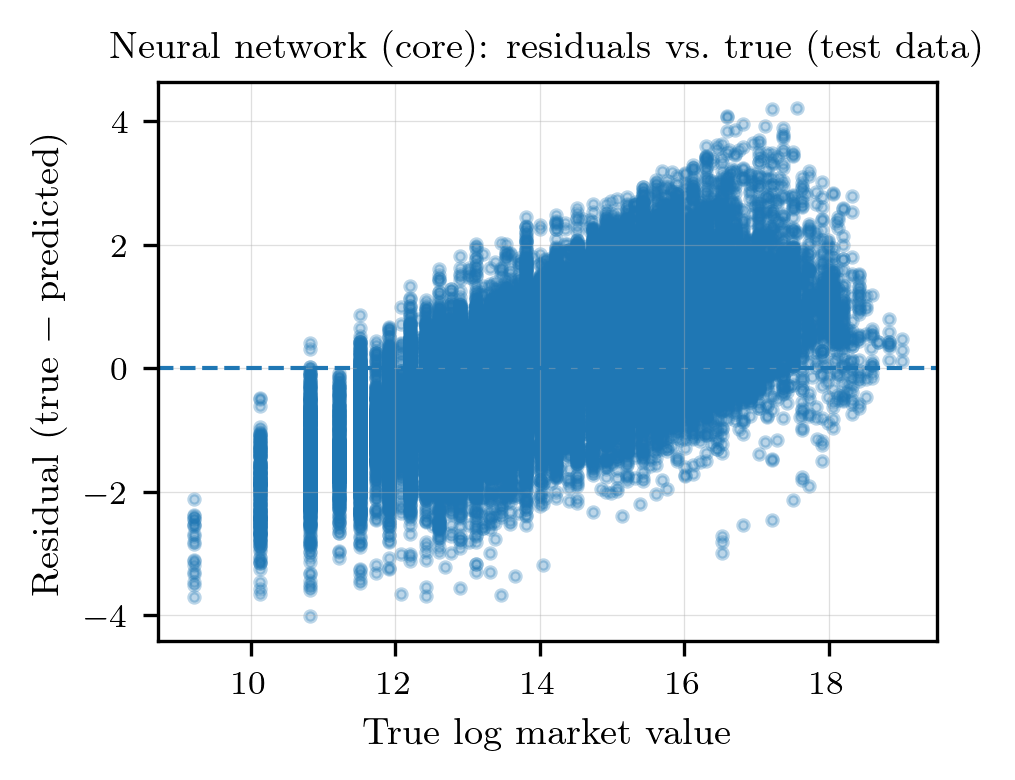

In [15]:
### pred vs true
set_latex_style(usetex=True)

fig, ax = fig_ax("onecol", height_scale=1.1)

ax.scatter(ytrue_test, yhat_test, s=6, alpha=0.3)

mn = min(ytrue_test.min(), yhat_test.min())
mx = max(ytrue_test.max(), yhat_test.max())
ax.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1.0)

ax.set_xlabel(r"True log market value")
ax.set_ylabel(r"Predicted log market value")
ax.set_title(r"Neural network (core): predicted vs.\ true (test data)")

ax.grid(True, which="both", linewidth=0.3, alpha=0.4)

save_pdf(fig, "fig_nn_core_pred_vs_true.pdf", folder="../Plots")

#res vs. true
fig, ax = fig_ax("onecol", height_scale=1.1)

ax.scatter(ytrue_test, residuals_test, s=6, alpha=0.3)
ax.axhline(0.0, linestyle="--", linewidth=1.0)

ax.set_xlabel(r"True log market value")
ax.set_ylabel(r"Residual (true $-$ predicted)")
ax.set_title(r"Neural network (core): residuals vs.\ true (test data)")

ax.grid(True, which="both", linewidth=0.3, alpha=0.4)

save_pdf(fig, "fig_nn_core_residuals.pdf", folder="../Plots")



### Old test (wrong!!!)

In [ ]:
X_train = data["X_train"]
X_test  = data["X_test"]
y_train = data["ylog_train"].ravel()
y_test  = data["ylog_test"].ravel()

# Torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=256, shuffle=True, num_workers=0)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=2048, shuffle=False, num_workers=0)

device = "cpu"  # change to "cuda" only if stable
torch.manual_seed(42)
np.random.seed(42)


def make_activation(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    if name == "tanh":
        return nn.Tanh()
    raise ValueError("activation must be 'relu' or 'tanh'")


class MLP(nn.Module):
    def __init__(self, d_in: int, n_layers: int, n_units: int, activation: str, dropout: float = 0.1):
        super().__init__()
        act = make_activation(activation)
        layers = []
        prev = d_in
        for _ in range(n_layers):
            layers.append(nn.Linear(prev, n_units))
            layers.append(act.__class__())  # new instance
            if dropout and dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = n_units
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


@torch.no_grad()
def eval_model(model: nn.Module):
    model.eval()
    preds = []
    trues = []
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds.append(pred)
        trues.append(yb.numpy())
    yhat = np.vstack(preds).ravel()
    ytrue = np.vstack(trues).ravel()
    rmse = np.sqrt(mean_squared_error(ytrue, yhat))
    r2 = r2_score(ytrue, yhat)
    return rmse, r2


def train_one_config(
    n_layers: int,
    n_units: int,
    activation: str,
    *,
    lr: float = 5e-4,
    weight_decay: float = 1e-5,
    dropout: float = 0.1,
    max_epochs: int = 40,
    patience: int = 6,
    clip_norm: float = 5.0,
):
    # reproducible init per config (optional but nice)
    torch.manual_seed(42)
    model = MLP(d_in=X_train.shape[1], n_layers=n_layers, n_units=n_units, activation=activation, dropout=dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    best_rmse = np.inf
    best_r2 = -np.inf
    best_epoch = 0
    best_state = None
    bad = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            if clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            opt.step()

        rmse, r2 = eval_model(model)

        if rmse < best_rmse - 1e-4:
            best_rmse = rmse
            best_r2 = r2
            best_epoch = epoch
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    # final metrics (best)
    rmse, r2 = eval_model(model)

    # count params
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return {
        "activation": activation,
        "n_layers": n_layers,
        "n_units": n_units,
        "n_params": int(n_params),
        "best_epoch": int(best_epoch),
        "rmse_log": float(rmse),
        "r2_log": float(r2),
    }


def run_sweep(activation: str, layers_grid, units_grid):
    rows = []
    t0 = time.time()

    for L in layers_grid:
        for H in units_grid:
            res = train_one_config(L, H, activation)
            rows.append(res)
            print(f"[{activation}] layers={L}, units={H} -> RMSE(log)={res['rmse_log']:.4f}, R2(log)={res['r2_log']:.4f}, best_epoch={res['best_epoch']}")

    df_res = pd.DataFrame(rows).sort_values(["n_layers", "n_units"]).reset_index(drop=True)
    print(f"Done {activation} sweep in {time.time()-t0:.1f}s")
    return df_res


# -----------------------------
# Sweep grids (as proposed)
# -----------------------------
layers_grid = [1, 2, 3]
units_grid  = [32, 64, 128, 256]

relu_results = run_sweep("relu", layers_grid, units_grid)
tanh_results = run_sweep("tanh", layers_grid, units_grid)

all_results = pd.concat([relu_results, tanh_results], ignore_index=True)

display(all_results)

# Optional: save to CSV (recommended for reproducibility)
all_results.to_csv("mlp_arch_sweep_results.csv", index=False)
print("Saved: mlp_arch_sweep_results.csv")


[relu] layers=1, units=32 -> RMSE(log)=1.0721, R2(log)=0.4933, best_epoch=35
[relu] layers=1, units=64 -> RMSE(log)=1.0706, R2(log)=0.4946, best_epoch=38
[relu] layers=1, units=128 -> RMSE(log)=1.0691, R2(log)=0.4961, best_epoch=30
[relu] layers=1, units=256 -> RMSE(log)=1.0703, R2(log)=0.4949, best_epoch=12
[relu] layers=2, units=32 -> RMSE(log)=1.0653, R2(log)=0.4996, best_epoch=39
[relu] layers=2, units=64 -> RMSE(log)=1.0669, R2(log)=0.4982, best_epoch=16
[relu] layers=2, units=128 -> RMSE(log)=1.0683, R2(log)=0.4968, best_epoch=9
[relu] layers=2, units=256 -> RMSE(log)=1.0709, R2(log)=0.4944, best_epoch=7
[relu] layers=3, units=32 -> RMSE(log)=1.0686, R2(log)=0.4965, best_epoch=17
[relu] layers=3, units=64 -> RMSE(log)=1.0661, R2(log)=0.4989, best_epoch=25
[relu] layers=3, units=128 -> RMSE(log)=1.0673, R2(log)=0.4977, best_epoch=8
[relu] layers=3, units=256 -> RMSE(log)=1.0651, R2(log)=0.4998, best_epoch=13
Done relu sweep in 8983.4s
[tanh] layers=1, units=32 -> RMSE(log)=1.0821,

,activation,n_layers,n_units,n_params,best_epoch,rmse_log,r2_log
0,relu,1,32,545,35,1.072084,0.493258
1,relu,1,64,1089,38,1.070633,0.494628
2,relu,1,128,2177,30,1.069056,0.496116
3,relu,1,256,4353,12,1.070342,0.494903
4,relu,2,32,1601,39,1.065311,0.499640
5,relu,2,64,5249,16,1.066893,0.498153
6,relu,2,128,18689,9,1.068348,0.496783
7,relu,2,256,70145,7,1.070890,0.494385
8,relu,3,32,2657,17,1.068603,0.496543
9,relu,3,64,9409,25,1.066052,0.498944


Saved: mlp_arch_sweep_results.csv


In [10]:
# Create pivot tables for heatmaps
relu_r2 = relu_results.pivot(index="n_layers", columns="n_units", values="r2_log")
tanh_r2 = tanh_results.pivot(index="n_layers", columns="n_units", values="r2_log")

relu_rmse = relu_results.pivot(index="n_layers", columns="n_units", values="rmse_log")
tanh_rmse = tanh_results.pivot(index="n_layers", columns="n_units", values="rmse_log")

print("ReLU R2 matrix:\n", relu_r2)
print("\nTanh R2 matrix:\n", tanh_r2)


ReLU R2 matrix:
 n_units        32        64        128       256
n_layers                                        
1         0.493258  0.494628  0.496116  0.494903
2         0.499640  0.498153  0.496783  0.494385
3         0.496543  0.498944  0.497734  0.499803

Tanh R2 matrix:
 n_units        32        64        128       256
n_layers                                        
1         0.483790  0.488413  0.490609  0.490447
2         0.494924  0.496981  0.496530  0.497461
3         0.495730  0.497175  0.496012  0.495503
